In [1]:
 import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from ccode.gates import rectangular_gate, half_disk_gate
from ccode.finite_system import finite_system
from scipy import constants
import matplotlib.pyplot as plt

import poisson
import kwant
from potential import gate_potential, linear_problem_instance
from plotting import plot_potential
from Hamiltonian import discrete_system_coordinates

from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


# Y-shaped geometry

#### Parameters

In [2]:
thickness_dielectric = 1
thickness_twoDEG = 1
thickness_gates = 3

grid_spacing_twoDEG = 0.5
grid_spacing_normal = 1
grid_spacing_dielectric = 1
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

In [48]:
# one only needs to define the arm length L, and the channel width
L = 100
width = 30
gap = 4

R = L/np.sqrt(2)

In [49]:
crds = site_coords[:, [0, 1, 2]]
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

# Build kwant system

a = 10e-9
R *= a
width *= a
l = 120 * a
w = 7 * a
boundaries = [xmin, xmax, ymin, ymax, min(grid_points[:, 2]), max(grid_points[:, 2])]
boundaries = np.array(boundaries) * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R+width/np.sqrt(2), 0],
                      [-(-R+width/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

In [4]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
total_width = 2*xmax
total_length = ymax

#### Make gate polygons using Shapely

In [5]:
Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))

def gate_coords(obj, difference = None, common = None, gap = None):
    
    if type(common) == np.ndarray:
        return np.array(list(obj.intersection(Polygon(common)).exterior.coords))
        
    else:
        if gap != None:
            return np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords))
        else:
            return np.array(list(obj.difference(Polygon(difference)).exterior.coords))


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']

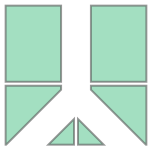

In [6]:
unary_union([Polygon(gate) for gate in gates_vertex])

#### Construct layout object for the Poisson solver

In [114]:
# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

thickness_back_gate = 2

height = -thickness_twoDEG/2 - (0.1 + thickness_dielectric) - (0.1 + thickness_back_gate)

layout.add_layer(PlanarGateLayer("back_gate", 
                                 thickness_back_gate, 
                                 permittivity_metal, 
                                 grid_spacing_gate, 
                                 gate_coords = [],
                                 second_layer = [],
                                 fix_overlap = False,
                                 z_bottom = height
                                )
                )
height += thickness_back_gate + 0.1

layout.add_layer(
    SimpleChargeLayer("Al2O3_b", thickness_dielectric, permittivity_Al2O3, grid_spacing_dielectric,
                     add_to_previous_layer = False,
                     z_bottom = height, fix_overlap = False)
)
height += thickness_dielectric + 0.1

layout.add_layer(
    SimpleChargeLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    ),
    center=True,
)

height += thickness_twoDEG

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3_t",
        thickness_dielectric,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_dielectric


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name = gates_name,
                                      gate_objects = gates_vertex,
                                      remove_points = False,
                                      add_to_previous_layer = False,
                                      z_bottom = height,
                                      fix_overlap = True
                                     )
            )


#### Build Poisson object

In [115]:
%%time

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 6min 55s, sys: 33.4 s, total: 7min 28s
Wall time: 7min 28s


In [116]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

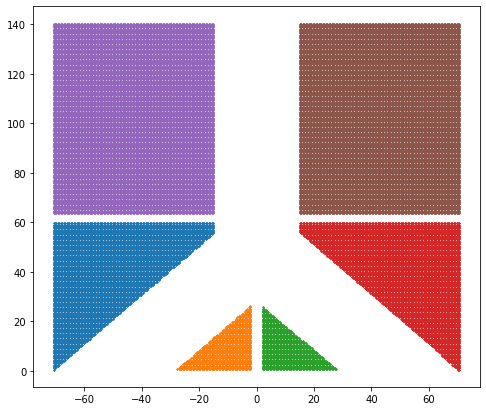

In [118]:
plt.figure(figsize = (8, 7))
for name, indices in voltage_regions.items():
    if name not in ['back_gate']:
        grid_to_plot = grid_points[indices][:, [0, 1]]
        plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### LU decomposition of finite system

In [119]:
%%time

linear_problem = linear_problem_instance(poisson_system)

CPU times: user 28.6 s, sys: 2.65 s, total: 31.3 s
Wall time: 31.1 s


In [120]:
grid_points= poisson_system.grid.points

In [121]:
charge_regions = poisson_system.regions.charge.tag_points

In [122]:
voltage_regions = poisson_system.regions.voltage.tag_points
regions_to_add = []
for region in voltage_regions.keys():
    if region not in ['dirichlet_0', 'dirichlet_1', 'dirichlet_2', 'dirichlet_3']:
        regions_to_add.append(('voltage', region))
for region in charge_regions.keys():
    # if region not in ['air']:
    regions_to_add.append(('charge', region))

In [123]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, regions_to_add, boundaries=None
)

#### Plot the potential across (x, z) that slices at [y = ? nm]

In [121]:
import tinyarray as ta
import math

grid = np.array(list(clean_potential.keys()))
unique_y = np.unique(grid[:, 1])
chosen_y_coords = unique_y[np.multiply(unique_y >= 5 * a, unique_y <= 20*a)]

grid = np.array(list(clean_potential.keys()))
total_potential = []

coordinates = grid[grid[:, 1] == chosen_y_coords[0]]
for i in chosen_y_coords[1:]:
    coordinates = np.append(coordinates, grid[grid[:, 1] == i], axis = 0)
    
for element in coordinates:
    total_potential.append(clean_potential[ta.array(element)])
    
    
filter_nan = list(map(lambda x: False if math.isnan(x) else True, total_potential))
total_potential = np.array(total_potential)[filter_nan]
coordinates = coordinates[filter_nan]

grid = (coordinates / a) * 10

#### Plot the grid across (x, z) plane that slices y at [y = ? nm]

Text(0, 0.5, 'Z [nm]')

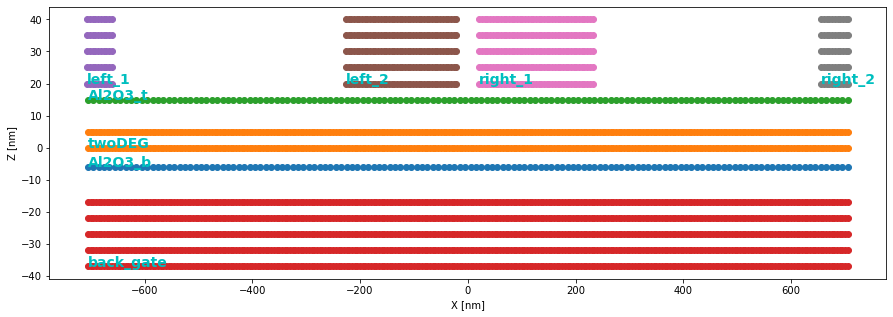

In [124]:
def filter_indices(points, minimum, maximum):
    data = np.unique(points[:, 1])
    chosen_y_coords = data[np.multiply(data >= minimum, data <= maximum)]
    if len(chosen_y_coords):
        return points[:, 1] == chosen_y_coords[0]
    else:
        return []
    
grid = grid_points.copy()

voltage_regions = {}
for key, indices in poisson_system.regions.voltage.tag_points.items():
    filtered_indices = filter_indices(grid[indices], 5, 20)
    voltage_regions[key] = indices[filtered_indices]
    
charge_regions = {}
for key, indices in poisson_system.regions.charge.tag_points.items():
    if key not in ['air', 'charge_default']:
        filtered_indices = filter_indices(grid[indices], 5, 20)
        charge_regions[key] = indices[filtered_indices]
        
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

for name, indices in charge_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')
            
for name, indices in voltage_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')

ax.set_xlabel('X [nm]')
ax.set_ylabel('Z [nm]')

#### Verify the potential

In [125]:
poisson_system.regions.voltage.tag_points

{'back_gate': array([ 51499,  51500,  51501, ..., 450526, 450527, 450528]),
 'left_1': array([650185, 650186, 650187, ..., 685887, 685888, 685889]),
 'left_2': array([685890, 685891, 685892, ..., 692722, 692723, 692724]),
 'right_1': array([692725, 692726, 692727, ..., 699477, 699478, 699479]),
 'right_2': array([699480, 699481, 699482, ..., 735092, 735093, 735094]),
 'top_1': array([735095, 735096, 735097, ..., 821332, 821333, 821334]),
 'top_2': array([821335, 821336, 821337, ..., 907572, 907573, 907574])}

In [126]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge', 'twoDEG')], boundaries=None
)

In [127]:
voltage_regions = list(poisson_system.regions.voltage.tag_points.keys())

In [130]:
voltages = {}
for region in voltage_regions: voltages[region] = 0.0e-3

In [202]:
voltages['left_1'] = -45.0
voltages['left_2'] = -45.0

voltages['right_1'] = -1.0
voltages['right_2'] = -1.0

voltages['top_1'] = -1.0
voltages['top_2'] = -1.0

voltages['back_gate'] = +0.5

In [203]:
voltages

{'back_gate': 0.5,
 'left_1': -45.0,
 'left_2': -45.0,
 'right_1': -1.0,
 'right_2': -1.0,
 'top_1': -1.0,
 'top_2': -1.0}

In [204]:
%%time

charges = {}
clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1, 2]],
        site_indices,
        voltages,
        charges,
        offset = offset,
        grid_spacing = a
    )

CPU times: user 2.65 s, sys: 249 ms, total: 2.9 s
Wall time: 2.89 s


In [205]:
coordinates = np.array(list(clean_potential.keys()))
        
x = coordinates[:, 0]
y = coordinates[:, 1]
width = np.unique(x).shape[0]
X = x.reshape(width, -1) / a
Y = y.reshape(width, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width, -1) * -1, 4)

In [206]:
from utility import HistogramNormalize

In [207]:
norm_Z = HistogramNormalize(Z)

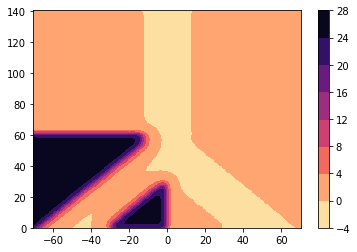

In [208]:
plt.figure()
# plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.contourf(X, Y, Z, cmap = 'magma_r')
plt.colorbar();

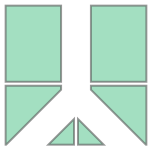

In [209]:
unary_union([Polygon(gate) for gate in gates_vertex])

#### Build kwant object

In [211]:
a = 10
(40*a-29*a)/2

55.0

In [110]:
%%time

trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

CPU times: user 876 ms, sys: 21 ms, total: 897 ms
Wall time: 892 ms


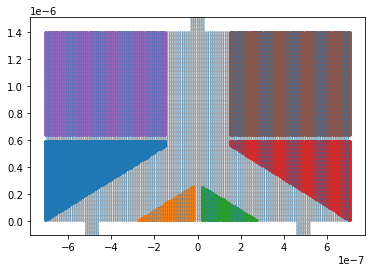

In [111]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-10*a, boundaries[3]+10*a)


for name, indices in voltage_regions.items():
    grid_to_plot = a*grid_points[indices][:, [0, 1]]
    ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### Define potential